In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# !ls

In [3]:
%cd TensorFlow-Advanced-Segmentation-Models
import tensorflow_advanced_segmentation_models as tasm

/home/work2/Workspace/sonnh/do_an_test/TensorFlow-Advanced-Segmentation-Models


2024-06-21 13:14:26.905599: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 13:14:26.924519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 13:14:26.924541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 13:14:26.924551: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-21 13:14:26.928295: I tensorflow/core/platform/cpu_feature_g

In [4]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-06-21 13:14:36.237698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 13:14:36.240572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 13:14:36.240646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [7]:
# tf.debugging.set_log_device_placement(True)

# # Create some tensors
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# print(c)

In [8]:

import os
# Data Handling

DATA_DIR = ""

x_train_dir = os.path.join(DATA_DIR, '../advanced-segmentation-structure/Dataset/TrainImage')
y_train_dir = os.path.join(DATA_DIR, '../advanced-segmentation-structure/Dataset/TrainMask')

x_valid_dir = os.path.join(DATA_DIR, '../advanced-segmentation-structure/Dataset/ValImage')
y_valid_dir = os.path.join(DATA_DIR, '../advanced-segmentation-structure/Dataset/ValMask')

x_test_dir = os.path.join(DATA_DIR, '../advanced-segmentation-structure/Dataset/TestImage')
y_test_dir = os.path.join(DATA_DIR, '../advanced-segmentation-structure/Dataset/TestMask')

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

In [10]:
def get_training_augmentation(height, width):
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0, value=0),
        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0, value=0),
        A.RandomCrop(height=height, width=width, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation(height, width):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(height, width),
        A.Resize(height, width, always_apply=True)
    ]
    return A.Compose(test_transform)

def data_get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [11]:
TOTAL_CLASSES = [ 'tree', 'water', 'road', 'house', 'background']
N_TOTAL_CLASSES = 5
# CLASSES_DICT = {"sky": 0, "building": 1, "pole": 2, "road": 3, "pavement": 4,
#                 "tree": 5, "signsymbol": 6, "fence": 7, "car": 8,
#                 "pedestrian": 9, "bicyclist": 10, "unlabelled": 11}
# Dervied from Matlab: https://it.mathworks.com/help/vision/examples/semantic-segmentation-using-deep-learning.html
CLASSES_PIXEL_COUNT_DICT = {"tree": 1,
                            "water": 2, "road": 3,
                            "house": 4, "background": 0}

MODEL_CLASSES = TOTAL_CLASSES
# ALL_CLASSES = False
# if MODEL_CLASSES == TOTAL_CLASSES:
#     MODEL_CLASSES = MODEL_CLASSES[:-1]
#     ALL_CLASSES = True
ALL_CLASSES = True

BATCH_SIZE = 2
N_CLASSES = len(MODEL_CLASSES)
HEIGHT = 256
WIDTH = 256
BACKBONE_NAME = "resnet50"
WEIGHTS = "imagenet"
WWO_AUG = False # train data with and without augmentation

In [12]:
import numpy as np
################################################################################
# Class Weights
################################################################################
def get_dataset_counts(d):
    pixel_count = np.array([i for i in d.values()])

    sum_pixel_count = 0
    for i in pixel_count:
        sum_pixel_count += i

    return pixel_count, sum_pixel_count

def get_dataset_statistics(pixel_count, sum_pixel_count):

    pixel_frequency = np.round(pixel_count / sum_pixel_count, 4)

    mean_pixel_frequency = np.round(np.mean(pixel_frequency), 4)

    return pixel_frequency, mean_pixel_frequency

def get_balancing_class_weights(classes, d):
    pixel_count, sum_pixel_count = get_dataset_counts(d)

    background_pixel_count = 0
    mod_pixel_count = []

    for c in TOTAL_CLASSES:
        if c not in classes:
            background_pixel_count += d[c]
        else:
            mod_pixel_count.append(d[c])

    if not ALL_CLASSES:
        mod_pixel_count.append(background_pixel_count)
    else:
        mod_pixel_count[:-1]

    pixel_frequency, mean_pixel_frequency = get_dataset_statistics(mod_pixel_count, sum_pixel_count)
    
    # Handling division by zero
    class_weights = np.zeros_like(pixel_frequency)
    non_zero_indices = pixel_frequency != 0
    class_weights[non_zero_indices] = np.round(mean_pixel_frequency / pixel_frequency[non_zero_indices], 2)
    return class_weights

    class_weights = np.round(mean_pixel_frequency / pixel_frequency, 2)
    return class_weights

# class_weights = get_balancing_class_weights(MODEL_CLASSES, CLASSES_PIXEL_COUNT_DICT)
class_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
print(class_weights)


[0.2, 0.2, 0.2, 0.2, 0.2]


In [13]:
################################################################################
# Data Generator
################################################################################
def create_image_label_path_generator(images_dir, masks_dir, shuffle=False, seed=None):
    ids = sorted(os.listdir(images_dir))
    mask_ids = sorted(os.listdir(masks_dir))

    if shuffle == True:

        if seed is not None:
            tf.random.set_seed(seed)

        indices = tf.range(start=0, limit=tf.shape(ids)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        ids = tf.gather(ids, shuffled_indices).numpy().astype(str)
        mask_ids = tf.gather(mask_ids, shuffled_indices).numpy().astype(str)

    images_fps = [os.path.join(images_dir, image_id) for image_id in ids]
    masks_fps = [os.path.join(masks_dir, image_id) for image_id in mask_ids]

    while True:
        for i in range(len(images_fps)):
            yield [images_fps[i], masks_fps[i]]


def process_image_label(images_paths, masks_paths, classes, augmentation=None, preprocessing=None, all_classes=False):
    class_values = [TOTAL_CLASSES.index(cls.lower()) for cls in classes]

    # read data
    image = cv2.imread(images_paths)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_paths, 0)

    # extract certain classes from mask (e.g. cars)
    masks = [(mask == v) for v in class_values]
    mask = np.stack(masks, axis=-1).astype('float')

    # add background if mask is not binary
    if mask.shape[-1] != 1 and not all_classes:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)

    # apply augmentations
    if augmentation:
        sample = augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # apply preprocessing
    if preprocessing:
        sample = preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # mask = np.squeeze(np.argmax(mask, axis=-1))
    # mask = np.argmax(mask, axis=-1)
    # mask = mask[..., np.newaxis]

    return image, mask

def DataGenerator(train_dir, label_dir, batch_size, height, width, classes, augmentation, all_classes=False, wwo_aug=False, shuffle=False, seed=None):
    image_label_path_generator = create_image_label_path_generator(
        train_dir, label_dir, shuffle=shuffle, seed=seed
    )
    if wwo_aug:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            if all_classes:
                labels = np.zeros(shape=[batch_size, height, width, len(classes)], dtype=np.float32)
            else:
                labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
            for i in range(0, batch_size, 2):
                image_path, label_path = next(image_label_path_generator)
                image_aug, label_aug = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation, all_classes=all_classes)
                image_wo_aug, label_wo_aug = process_image_label(image_path, label_path, classes=classes, augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH), all_classes=all_classes)
                images[i], labels[i] = image_aug, label_aug
                images[i + 1], labels[i + 1] = image_wo_aug, label_wo_aug

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)
    else:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            if all_classes:
                labels = np.zeros(shape=[batch_size, height, width, len(classes)], dtype=np.float32)
            else:
                labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
            for i in range(batch_size):
                image_path, label_path = next(image_label_path_generator)
                image, label = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation, all_classes=all_classes)
                images[i], labels[i] = image, label

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)

In [14]:
# import tensorflow_advanced_segmentation_models as tasm
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
# model = tasm.DANet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)
model = tasm.HRNetOCR(n_classes=N_CLASSES)


2024-06-21 13:14:36.284137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 13:14:36.284232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 13:14:36.284274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
# import tensorflow as tf
# opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
opt = tf.keras.optimizers.Adam()
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = 2 * tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss(class_weights=class_weights)
# categorical_focal_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0)
# dice_loss = tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ModelCheckpoint("../HRNetOCR_weights/HRNetOCR.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
            #  tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
            #  tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [16]:

# print(model.summary())

In [17]:
train_shuffle = False
val_shuffle = False
seed = 29598

TrainSet = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=train_shuffle,
    seed=seed
    )

TrainSetwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=train_shuffle,
    seed=seed
)

TrainSetwwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    wwo_aug=True,
    shuffle=train_shuffle,
    seed=seed
)

ValidationSet = DataGenerator(
    x_valid_dir,
    y_valid_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=val_shuffle,
    seed=seed
)

TestSet = DataGenerator(
    x_test_dir,
    y_test_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=False
)

# for i in TrainSet:
#     sample_image, sample_mask = i[0][0], i[1][0]
#     print(len(i))
#     print(i[0].shape)
#     print(i[1].shape)
#     break

print(len(os.listdir(x_train_dir)))
print(len(os.listdir(x_valid_dir)))
print(len(os.listdir(x_test_dir)))

3114
389
390


In [18]:
for i in TrainSet:
    sample_image, sample_mask = i[0][0], i[1][0]
    print(len(i))
    print(i[0].shape)
    print(i[1].shape)
    break

2
(2, 256, 256, 3)
(2, 256, 256, 5)


2024-06-21 13:14:37.388496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


SparseCategoricalCrossentroy: 15.488482
Iou-Score: 1.376083e-09
categorical Focal Dice Loss: 2.5488477


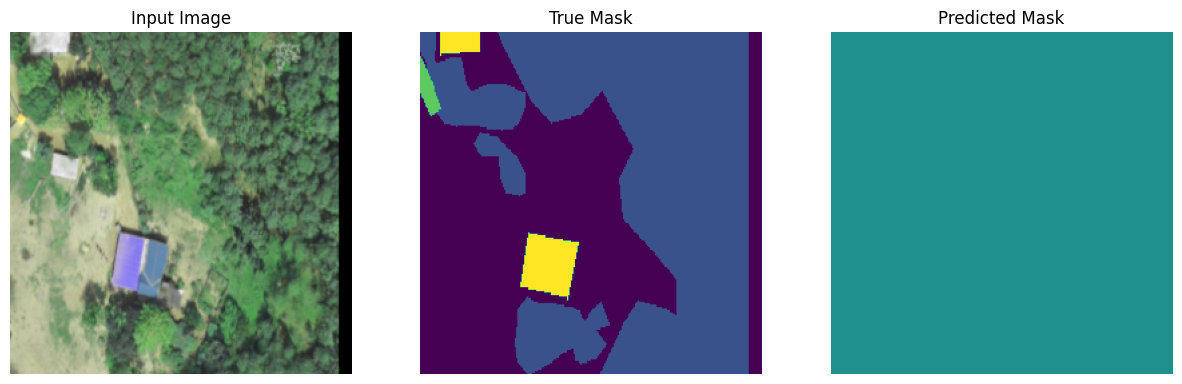

In [19]:
vmin = 0
vmax = 4
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
          plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else: 
          plt.imshow(display_list[i], vmin=vmin, vmax=vmax)
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):

    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    output_model = model(sample_image[tf.newaxis, ...])
    # print(output_model.numpy())

    output_mask = create_mask(output_model)
    # print(sample_mask.shape)

    scce = tf.keras.losses.CategoricalCrossentropy()
    print("SparseCategoricalCrossentroy: " + str(scce(sample_mask, output_model[0]).numpy()))
    # print(iou_score(sample_mask, output_model[0]))
    print("Iou-Score: " + str(tasm.losses.iou_score(sample_mask[tf.newaxis, ...], output_model, class_weights=class_weights).numpy()))
    # print("Dice Loss: " + str(dice_loss(sample_mask, output_model[0]).numpy()))
    # print("Categorical Focal Loss: " + str(categorical_focal_loss(sample_mask, output_model[0]).numpy()))
    print("categorical Focal Dice Loss: " + str(categorical_focal_dice_loss(sample_mask[tf.newaxis, ...], output_model).numpy()))

    display([sample_image, tf.argmax(sample_mask, axis=-1)[..., tf.newaxis], output_mask]) # K.one_hot(K.squeeze(output_mask, axis=-1), 3)])

show_predictions()

In [20]:
# freezed
# for layer in model.layers:
#     if "functional" in layer.name:
#         layer.trainable = False

#     print(layer.name + ": " + str(layer.trainable))

In [21]:
# unfreezed
# for layer in model.layers:
#     layer.trainable = True

#     print(layer.name + ": " + str(layer.trainable))

# for layer in base_model.layers:
#     if ("block4" in layer.name):
#         layer.trainable = True

In [22]:
steps_per_epoch = np.floor(len(os.listdir(x_train_dir)) / BATCH_SIZE)

history = model.fit(
    TrainSetwwoAug,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    callbacks=callbacks,
    validation_data=ValidationSet,
    validation_steps=len(os.listdir(x_valid_dir)),
)

Epoch 1/200


2024-06-21 13:14:50.165515: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x59caad1b8f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-21 13:14:50.165534: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-21 13:14:50.173439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-21 13:14:50.239335: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   3/1557 [..............................] - ETA: 7:14:42 - loss: 1.1192 - iou_score: 0.1169

KeyboardInterrupt: 

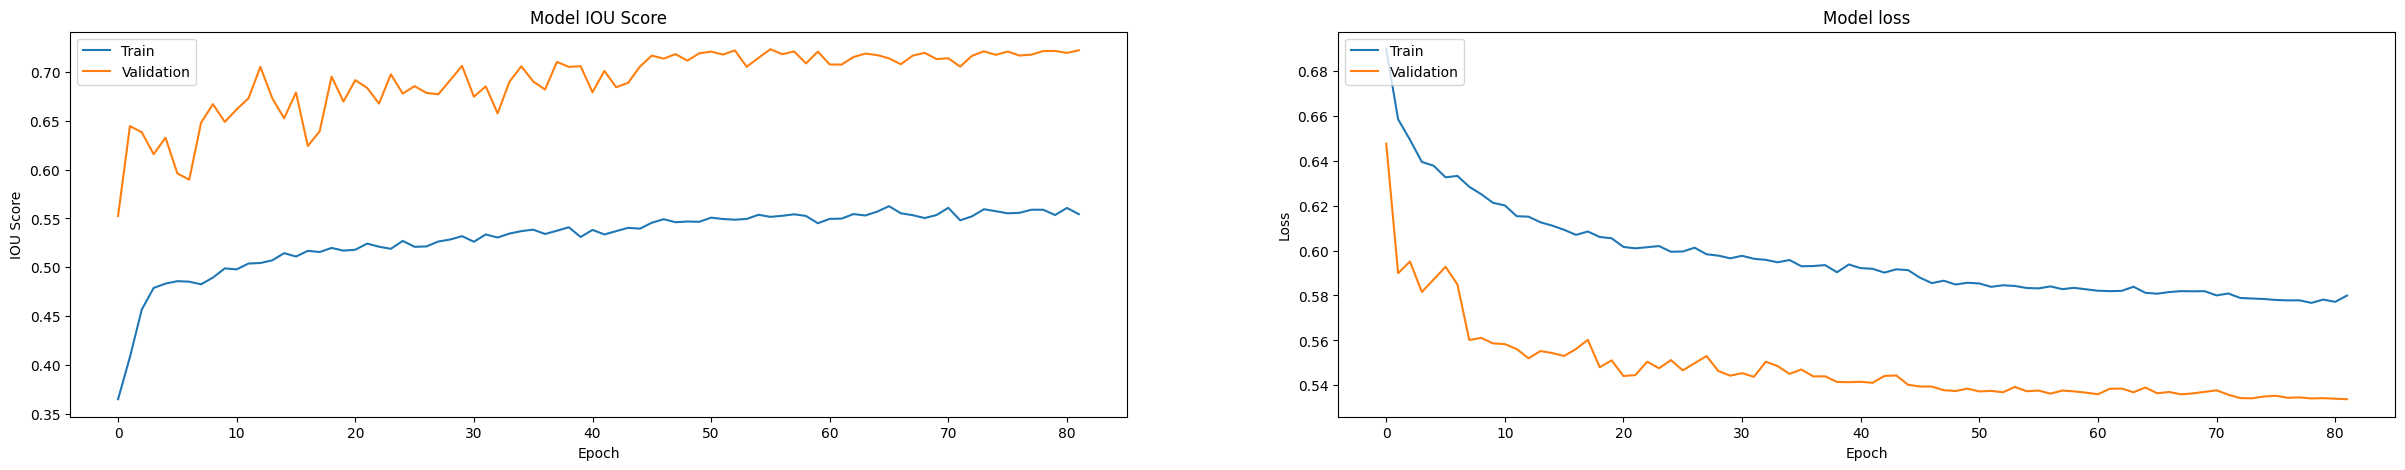

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(TestSet, steps=101)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    if metric != "accuracy":
        metric = metric.__name__
    print("mean {}: {:.5}".format(metric, value))


101/101 [==============================] - 3s 27ms/step - loss: 0.5443 - iou_score: 0.7233
Loss: 0.54434
mean iou_score: 0.72329


[45 28 90 21 63 22 14 66 84 94]
14
1/1 [==============================] - 0s 30ms/step


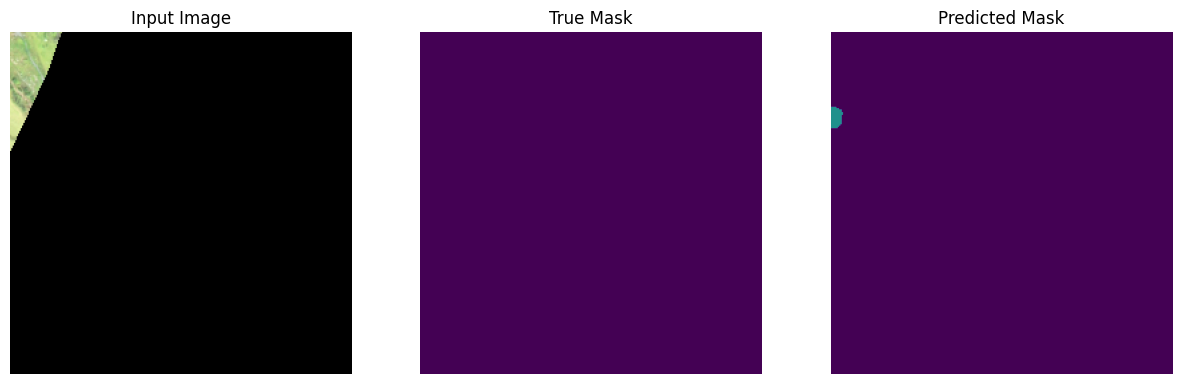

21
1/1 [==============================] - 0s 30ms/step


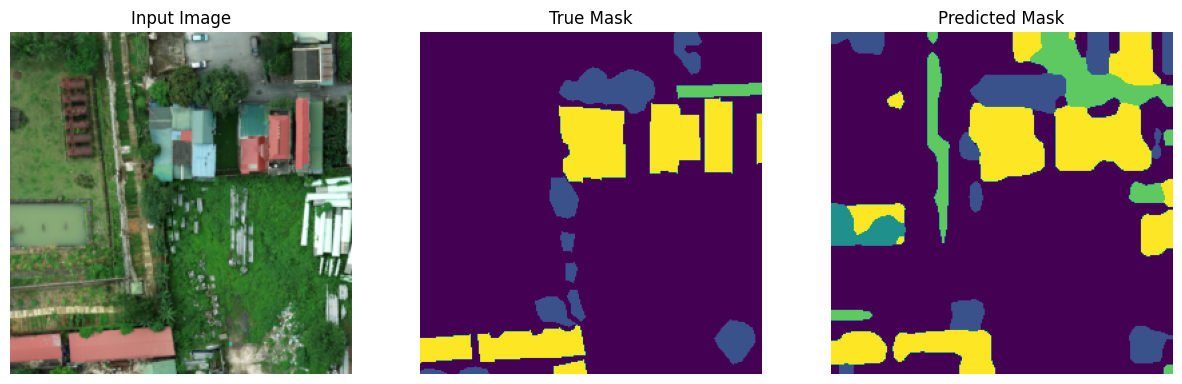

22
1/1 [==============================] - 0s 29ms/step


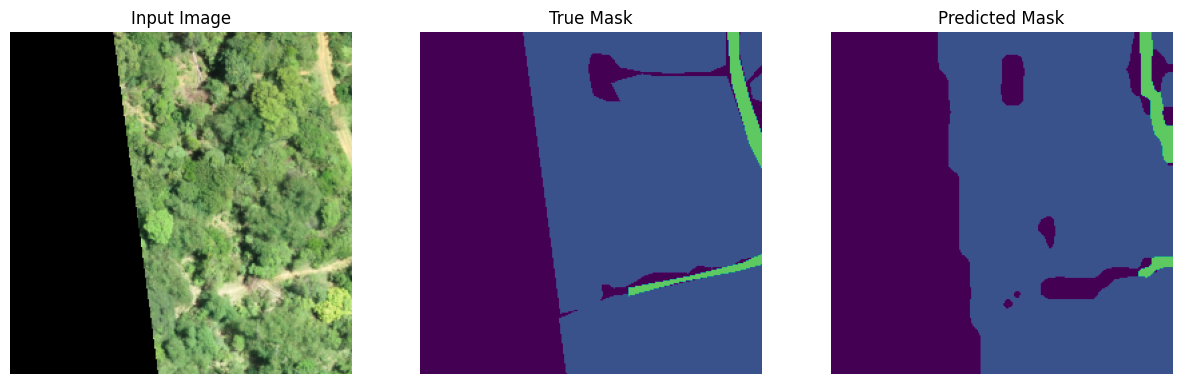

28
1/1 [==============================] - 0s 30ms/step


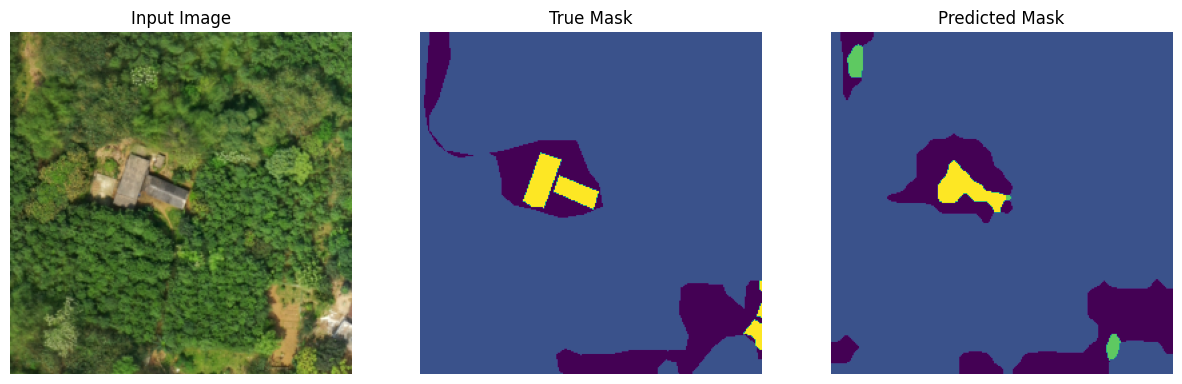

45
1/1 [==============================] - 0s 30ms/step


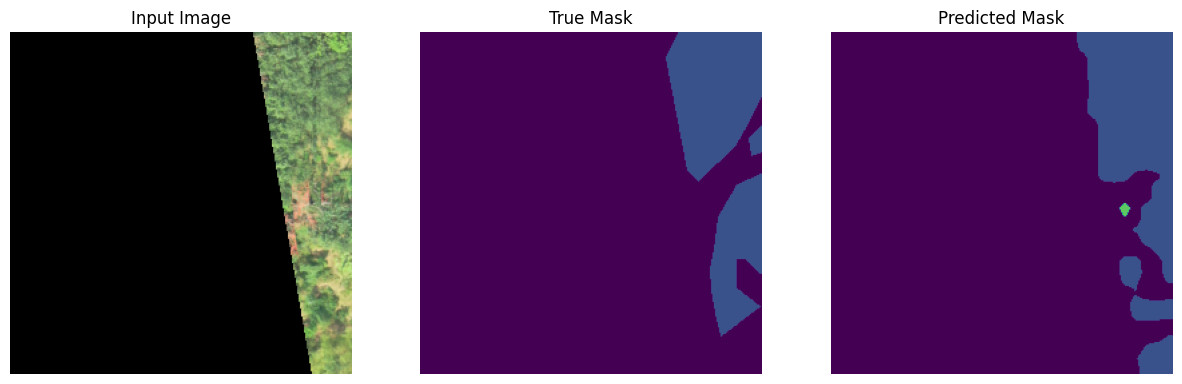

63
1/1 [==============================] - 0s 30ms/step


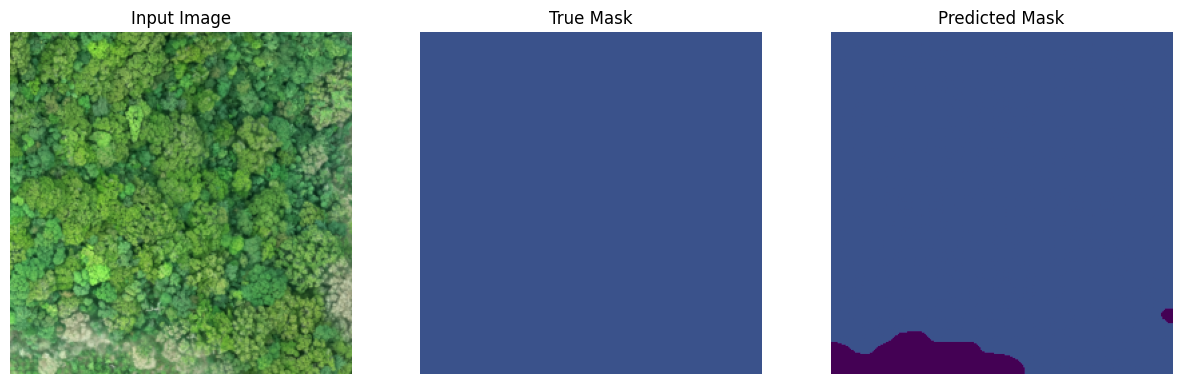

66
1/1 [==============================] - 0s 30ms/step


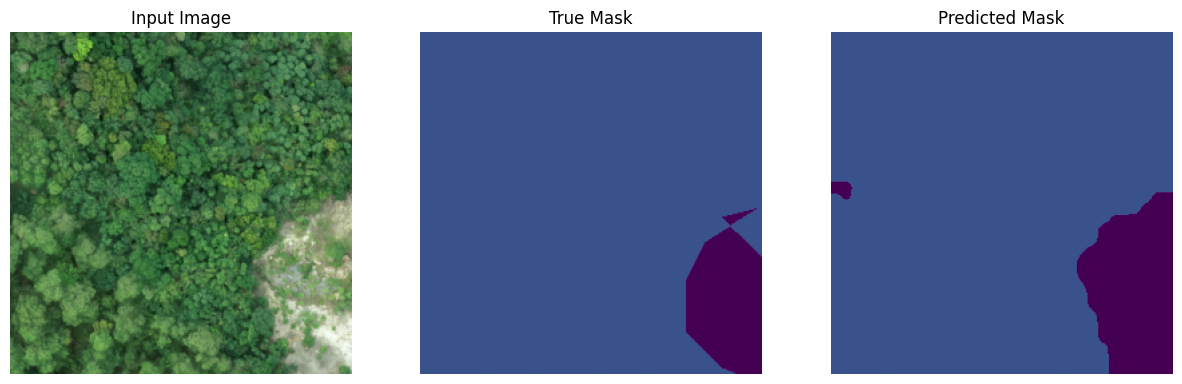

84
1/1 [==============================] - 0s 30ms/step


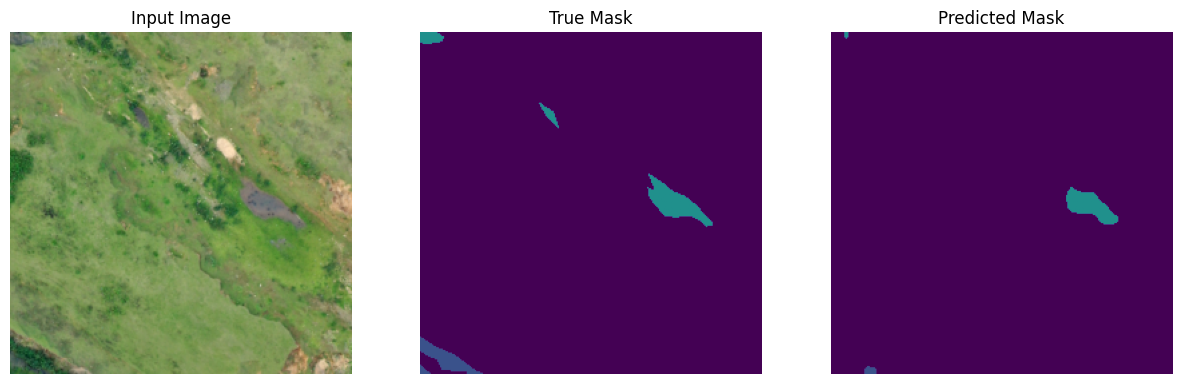

90
1/1 [==============================] - 0s 29ms/step


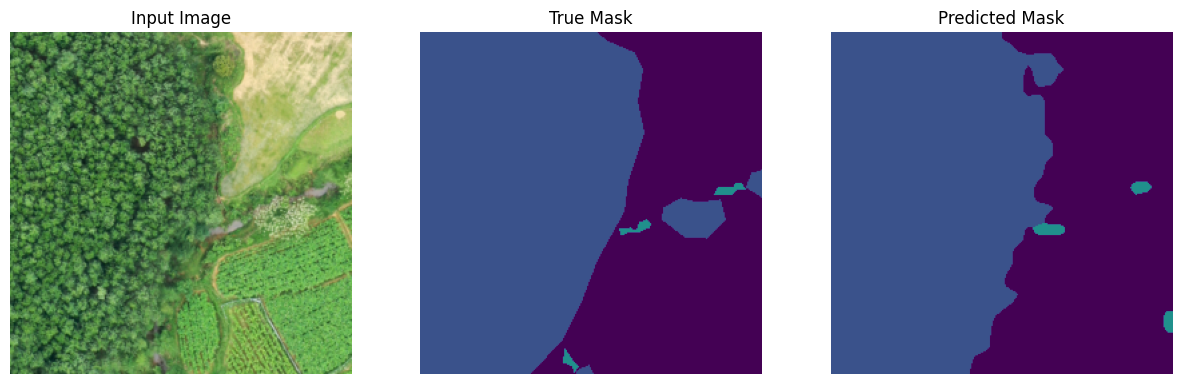

94
1/1 [==============================] - 0s 30ms/step


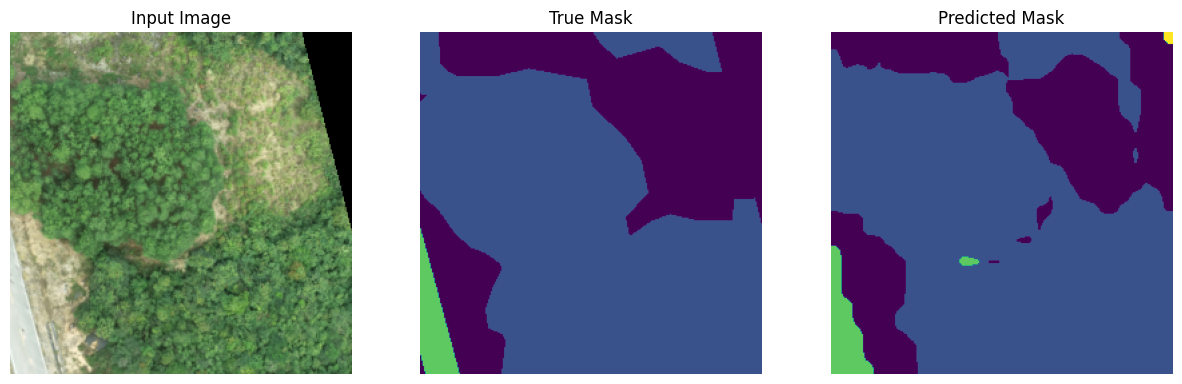

In [ ]:
n = 10
ids = np.random.choice(np.arange(101), size=n,replace=False)
print(ids)

counter = 0
second_counter = 0

for i in TestSet:
    if counter in ids:
        print(counter)
        image, gt_mask = i

        output_model = model.predict(image)
        output_mask = create_mask(output_model)

        display([image[0], tf.argmax(gt_mask[0], axis=-1)[..., tf.newaxis], output_mask])

        second_counter += 1
    counter += 1
    if second_counter == n:
        break